In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)
test_generator = ImageDataGenerator(rescale = 1./255)

In [7]:
IMAGE_DIR = "/content/drive/MyDrive/Manufacturing Defect/archive/casting_data/casting_data/"
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = (300,300),
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},
                shuffle = True,
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(directory = "/content/drive/MyDrive/Manufacturing Defect/archive/casting_data/casting_data/train", subset = "training", **gen_args)
validation_dataset = train_generator.flow_from_directory(directory = "/content/drive/MyDrive/Manufacturing Defect/archive/casting_data/casting_data/train", subset = "validation", **gen_args)
test_dataset = test_generator.flow_from_directory(directory = "/content/drive/MyDrive/Manufacturing Defect/archive/casting_data/casting_data/test", **gen_args)

Found 5115 images belonging to 2 classes.
Found 1277 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [8]:
model = Sequential([
        Conv2D(filters = 16, kernel_size = 3, strides = 2, activation = "relu", input_shape = (300,300,1)),
        MaxPooling2D(pool_size = 2, strides = 2),
        Conv2D(filters = 32, kernel_size = 3, strides = 2, activation = "relu"),
        MaxPooling2D(pool_size = 2, strides = 2),
        Flatten(),
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        Dense(1, activation = "sigmoid")
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 149, 149, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1327232   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [9]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [10]:
STEPS = 80
checkpoint = ModelCheckpoint("casting_defect.h5", verbose = 1, save_best_only = True, monitor = "loss")
model.fit_generator(generator = train_dataset, validation_data = validation_dataset, steps_per_epoch = STEPS, epochs = 50, validation_steps = STEPS, callbacks = [checkpoint], verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
80/80 [==============================] - 1525s 19s/step - loss: 0.6428 - accuracy: 0.6106 - val_loss: 0.6147 - val_accuracy: 0.6366

Epoch 00001: loss improved from inf to 0.64276, saving model to casting_defect.h5
Epoch 2/50
80/80 [==============================] - 53s 663ms/step - loss: 0.5305 - accuracy: 0.7122

Epoch 00002: loss improved from 0.64276 to 0.53050, saving model to casting_defect.h5
Epoch 3/50
80/80 [==============================] - 52s 653ms/step - loss: 0.4579 - accuracy: 0.7793

Epoch 00003: loss improved from 0.53050 to 0.45793, saving model to casting_defect.h5
Epoch 4/50
80/80 [==============================] - 52s 653ms/step - loss: 0.3577 - accuracy: 0.8336

Epoch 00004: loss improved from 0.45793 to 0.35770, saving model to casting_defect.h5
Epoch 5/50
80/80 [==============================] - 52s 655ms/step - loss: 0.2952 - accuracy: 0.8737

Epoch 00005: loss improved from 0.35770 to 0.29524, saving model to casting_defect.h5
Epoch 6/50
80/80 [====

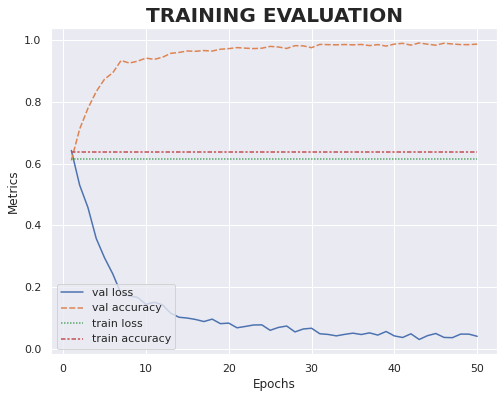

In [11]:
import pandas as pd
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [13]:
best_model = load_model("/content/casting_defect.h5")
y_pred_prob = best_model.predict_generator(generator = test_dataset, verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


12/12 [==============================] - 3s 227ms/step


In [18]:
mapping_class = {0: "ok", 1: "defect"}
THRESHOLD = 0.5
IMAGE_SIZE = (300,300)

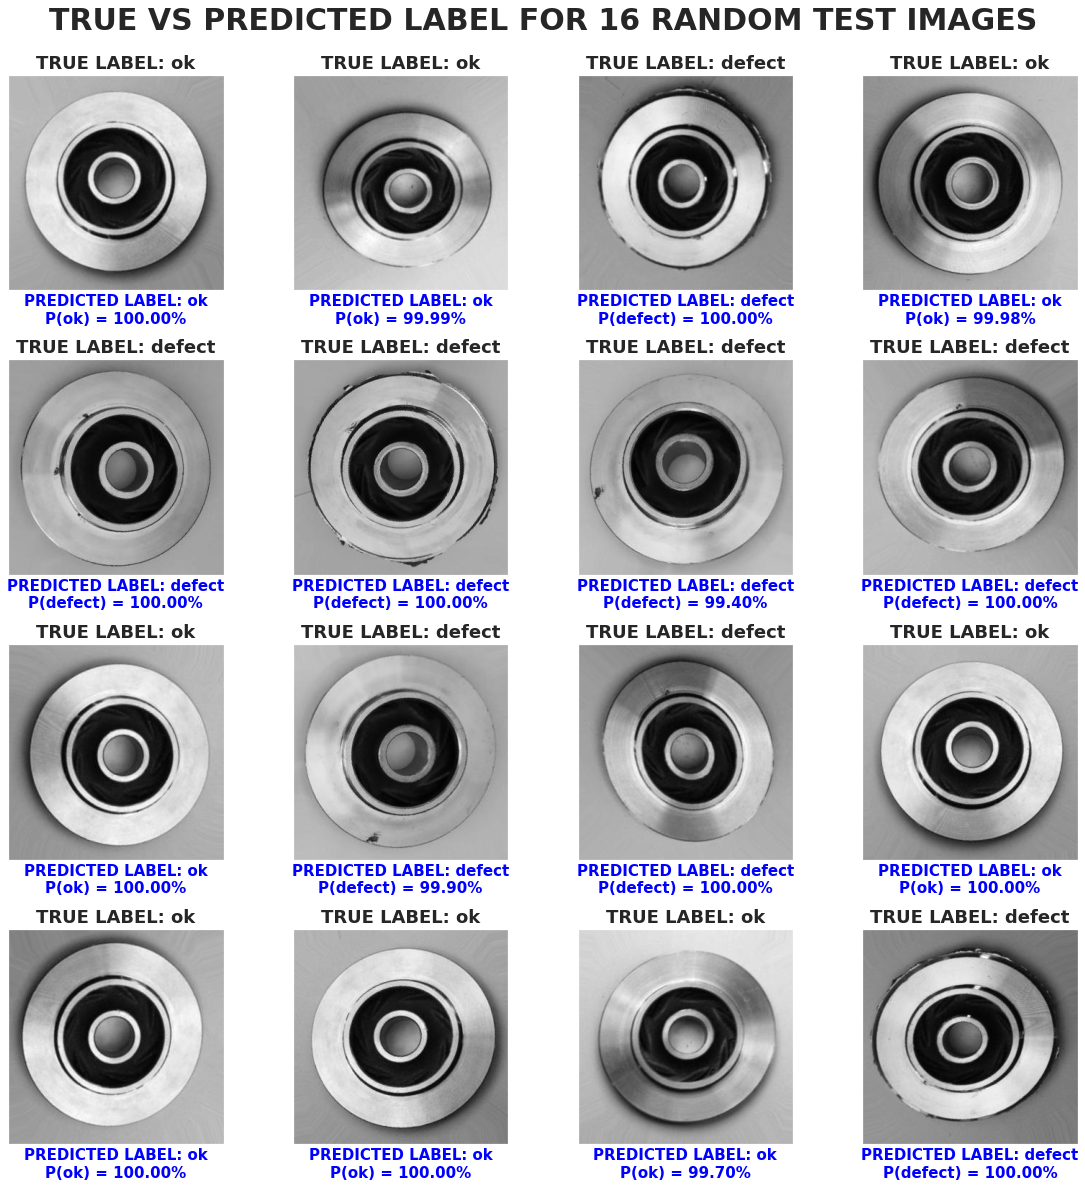

In [20]:
images, labels = next(iter(test_dataset))
images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap = "gray")
    true_label = mapping_class[label]
    
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nP({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("TRUE VS PREDICTED LABEL FOR 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()